<a href="https://colab.research.google.com/github/alouvre/CapstoneNeeds/blob/main/Receipt_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Receipt OCR notebook series: Problem definition**



We will break down this problem into smaller tasks:

Diberikan sebuah foto sembarang yang berisi struk, ekstrak total keseluruhan

1. **Dapatkan versi yang discan dari struk dengan mengembalikan perspektif.**
2. Terapkan OCR untuk menemukan semua teks dalam gambar.
3. Temukan Grand Total sebagai angka terbesar di antara teks yang terdeteksi.

One should remember that some tasks could be solved with traditional computer vision algorithms

This work aims to address a common pitfall among machine learning practitioners: trying to solve simple problems with the complex tools.

# **Set Environment**

In [ ]:
# Set Kaggle

# Menginstall kaggle
!pip install -q kaggle
# Membuat direktori
!mkdir ~/.kaggle
# Menyalin kaggle.json ke dir kaggle
!cp kaggle.json ~/.kaggle/
# Meminta izin untuk akses
!chmod 600 ~/.kaggle/kaggle.json

!kaggle -h

mkdir: cannot create directory ‘/root/.kaggle’: File exists
usage: kaggle [-h] [-v] {competitions,c,datasets,d,kernels,k,models,m,files,f,config} ...

options:
  -h, --help            show this help message and exit
  -v, --version         show program's version number and exit

commands:
  {competitions,c,datasets,d,kernels,k,models,m,files,f,config}
                        Use one of:
                        competitions {list, files, download, submit, submissions, leaderboard}
                        datasets {list, files, download, create, version, init, metadata, status}
                        kernels {list, init, push, pull, output, status}
                        config {view, set, unset}
    competitions (c)    Commands related to Kaggle competitions
    datasets (d)        Commands related to Kaggle datasets
    kernels (k)         Commands related to Kaggle kernels
    files (f)           Commands related files
    config              Configuration settings


# **Preparation**

In [ ]:

import numpy as np                            # Array dan Operasi Matematika
import cv2                                    # Manipulasi Gambar dan Pengolahan Citra
import matplotlib.pyplot as plt               # Visualisasi Data

from skimage.filters import threshold_local   # Pengolahan Gambar dan Metode Thresholding
from PIL import Image                         # Manipulasi Gambar dalam Format PIL

In [ ]:
# Mengunduh dataset
!kaggle datasets download -d 'dmitryyemelyanov/personal-receipt-collection'

 59% 8.00M/13.6M [00:00<00:00, 83.7MB/s]
100% 13.6M/13.6M [00:00<00:00, 114MB/s] 


In [ ]:
import zipfile

# Membuat direktori dataset
!mkdir dataset

# # Mengekstraksi file zip
nama_file_zip = 'personal-receipt-collection.zip'
nama_folder_tujuan = 'dataset'
dataset_zip = zipfile.ZipFile(nama_file_zip,'r')
dataset_zip.extractall('dataset')
dataset_zip.close()

# Memindahkan files ke direktori dataset
!mv personal-receipt-collection.zip dataset

mkdir: cannot create directory ‘dataset’: File exists


# **Receipt OCR Part 1**

This is a part one notebook in the Receipt OCR with OpenCV series and will cover the first step of the process: getting a scanned version of the receipt. In order to complete this task we will:

- Locate receipt contour on the photo
- Crop image to the receipt contour
- Apply perspective restoration

Let's get started!

Receipt images used in this notebook come from a tiny personal receipt dataset. Let's check out one of them:

<ipython-input-18-552059cb2d67>:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img.thumbnail((800,800), Image.ANTIALIAS)


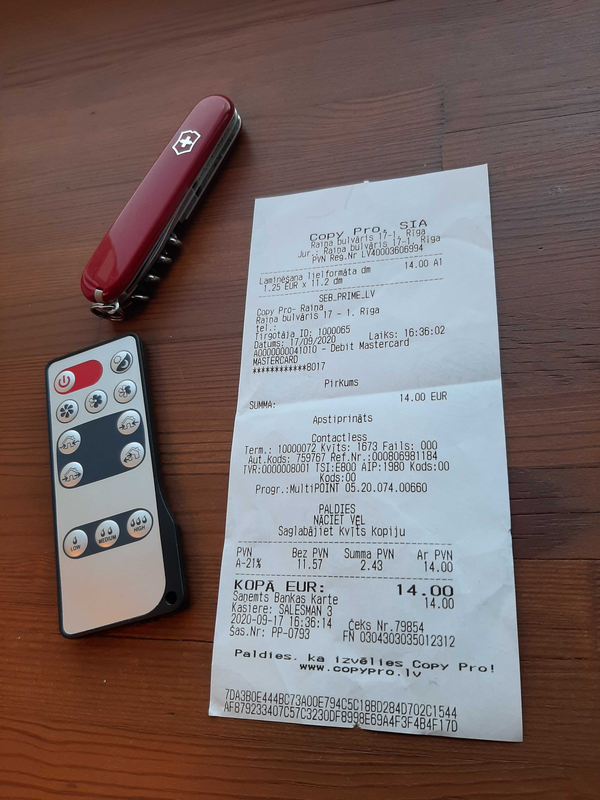

In [ ]:
# FYI : Ambil sampel dari dataset

file_name = 'dataset/20201007_110604.jpg' # Menentukan nama file gambar yang digunakan
img = Image.open(file_name)               # Membuka file gambar, hasil disimpan di img
img.thumbnail((800,800), Image.ANTIALIAS) # Mengubah ukuran gambar menjadi ukuran thumbnail maksimum 800x800
# Menampilkan gambar setelah di-load dan di-resize
img

## **Step 1: Receipt Contour Detection**
In order to find receipt contour, standart edge detection preprocessing is applied:

1. Convert image to grayscale
2. Aplly Gaussian filter 5x5 to get rid of noise
3. Run Canny edge detector

Let's define some utility methods:

In [91]:
# Fungsi meresize gambar
def opencv_resize(image, ratio):
    # Menghitung lebar baru berdasarkan rasio
    # image.shape[1] mengakses lebar gambar
    width = int(image.shape[1] * ratio)
    # Menghitung tinggi baru berdasarkan rasio
    # image.shape[0] mengakses tinggi gambar
    height = int(image.shape[0] * ratio)
    # Menyusun dimensi baru sebagai tuple (lebar, tinggi) setelah resizing
    dim = (width, height)
    # Melakukan resizing menggunakan cv2.resize() dengan metode interpolasi INTER_AREA
    # Dalam hal ini, INTER_AREA digunakan, yang cocok untuk meresize gambar dengan faktor scaling yang kecil.
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

In [ ]:
# Fungsi menampilkan gambar dalam format RGB
def plot_rgb(image):
    # Membuat objek gambar baru dengan ukuran 16x10 inci
    plt.figure(figsize=(16,10))
    # Mengubah format warna gambar dari BGR (OpenCV) ke RGB (matplotlib)
    # Sebagian besar fungsi plotting di matplotlib mengharapkan gambar dalam format RGB
    # Menampilkan gambar yang sudah diubah formatnya
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [ ]:
# Fungsi menampilkan gambar dalam skala abu-abu (grayscale)
def plot_gray(image):
    # Membuat objek gambar baru dengan ukuran 16x10 inci
    plt.figure(figsize=(16,10))
    # Menampilkan gambar dalam skala abu-abu dengan colormap 'Greys_r'
    return plt.imshow(image, cmap='Greys_r')

In [ ]:
# FYI : Memuat gambar dan melakukan penurunan skala pada gambar

# Baca gambar dari file gambar yang ditentukan
image = cv2.imread(file_name)

# Downscale image as finding receipt contour is more efficient on a small image

# Periksa apakah gambar berhasil dimuat
# Jika tidak, mencetak pesan kesalahan
if image is None:
    print(f"Error: Tidak dapat membaca gambar di {file_name}")
else:
    # Jika gambar berhasil dimuat
    # Lanjutkan dengan kode pemrosesan gambar

    # Hitung rasio perubahan skala untuk menurunkan ukuran gambar
    resize_ratio = 500 / image.shape[0]
    # Buat salinan gambar asli sebagai referensi bila diperlukan nantinya
    original = image.copy()
    # Ubah ukuran gambar menggunakan fungsi opencv_resize
    image = opencv_resize(image, resize_ratio)

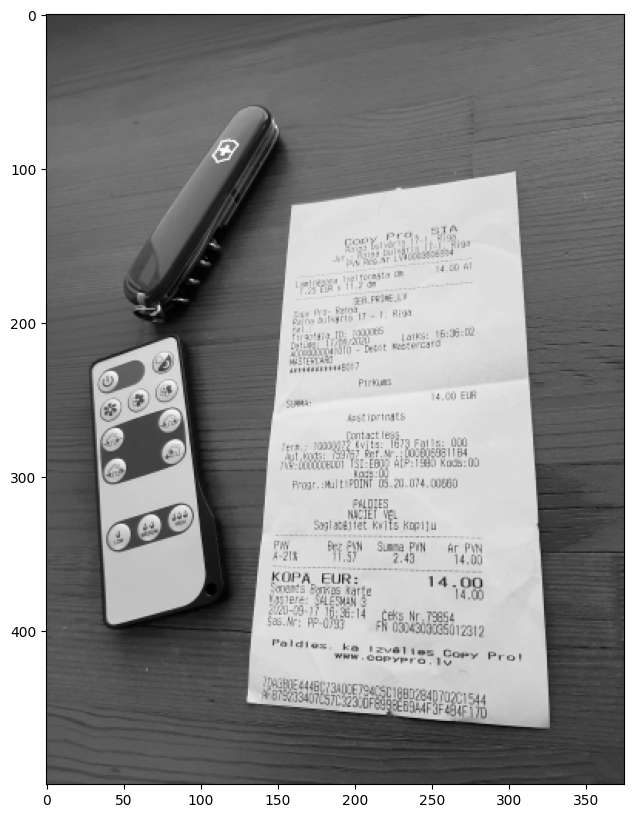

In [ ]:
# Konversi gambar ke skala abu-abu

# Konversi gambar dari format warna BGR (Blue, Green, Red) ke skala abu-abu untuk proses lanjutan
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Tampilkan gambar dalam skala abu-abu
plot_gray(gray)

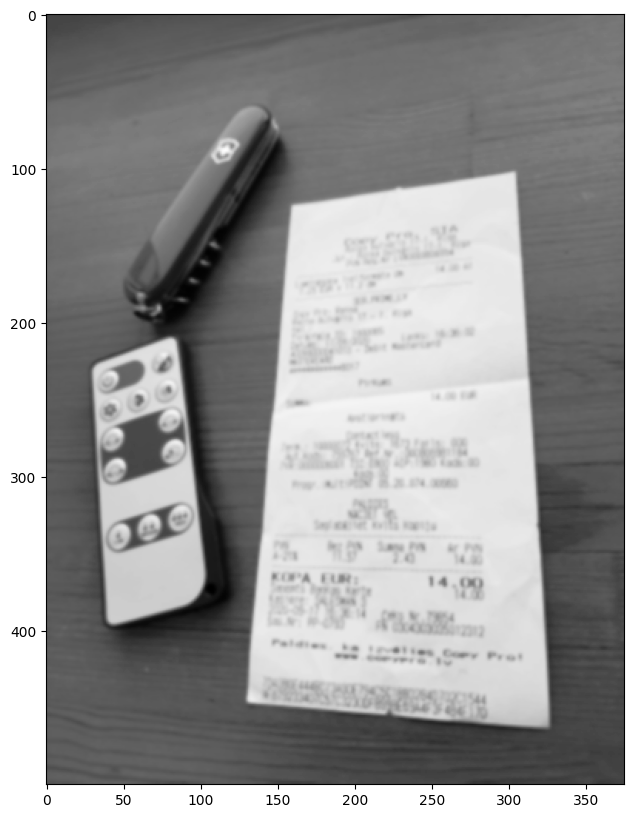

In [ ]:
# FYI : Mengurangi noise agar gambar lebih halus
# untuk mempermudah dalam proses deteksi tepi atau segmentasi objek

# Menghilangkan noise pada gambar skala abu-abu
# Parameter (5, 5) adalah ukuran kernel blur, yang menentukan seberapa banyak piksel
# di sekitar setiap piksel yang akan diambil untuk menghitung nilai rata-rata
# Parameter terakhir (0) adalah deviasi standar, yang mempengaruhi
# seberapa tajam efek blurnya.
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
# Tampilkan gambar yang telah di-blur
plot_gray(blurred)

Operasi morfologi seperti dilatasi digunakan untuk memodifikasi struktur gambar, dan dalam konteks ini, dapat membantu dalam meningkatkan kontras dan mendeteksi daerah-daerah terang pada gambar.

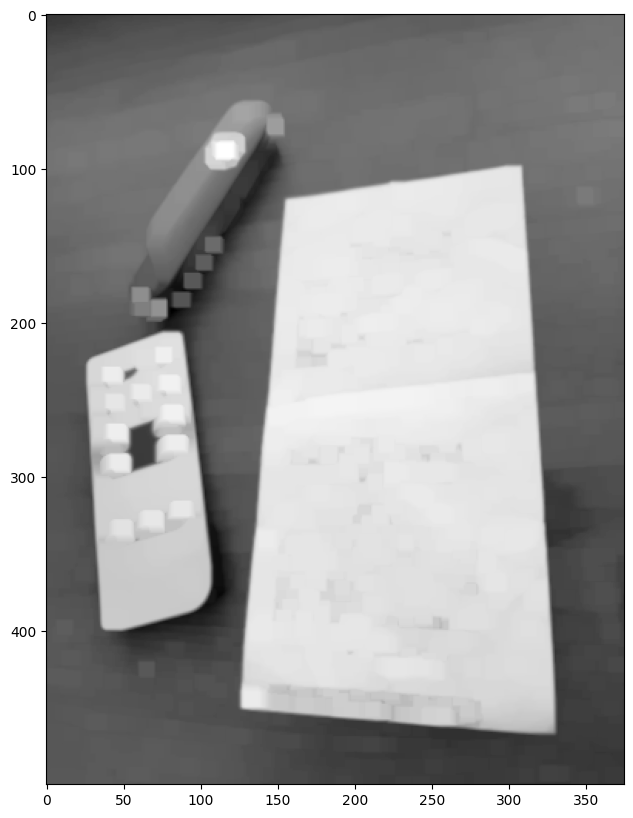

In [66]:
# Deteksi daerah putih pada gambar yang telah di-blur
# Melibatkan penggunaan operasi morfologi, khususnya dilatasi,
# untuk memperluas daerah-daerah terang

# Buat kernel morfologi persegi panjang dengan ukuran 9x9 piksel
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
# Operasi dilatasi pada gambar yang telah di-blur
# Dilatasi menghasilkan pengembangan daerah-daerah terang pada gambar,
# yang dapat membantu dalam mendeteksi fitur atau objek tertentu
dilated = cv2.dilate(blurred, rectKernel)
# Tampilkan gambar yang telah di-dilate
plot_gray(dilated)

Operator Canny umumnya digunakan untuk mendeteksi tepi dalam gambar. Ini bekerja dengan menggunakan metode deteksi gradien untuk menemukan perubahan intensitas yang signifikan dalam gambar, yang sering kali terkait dengan tepi objek.

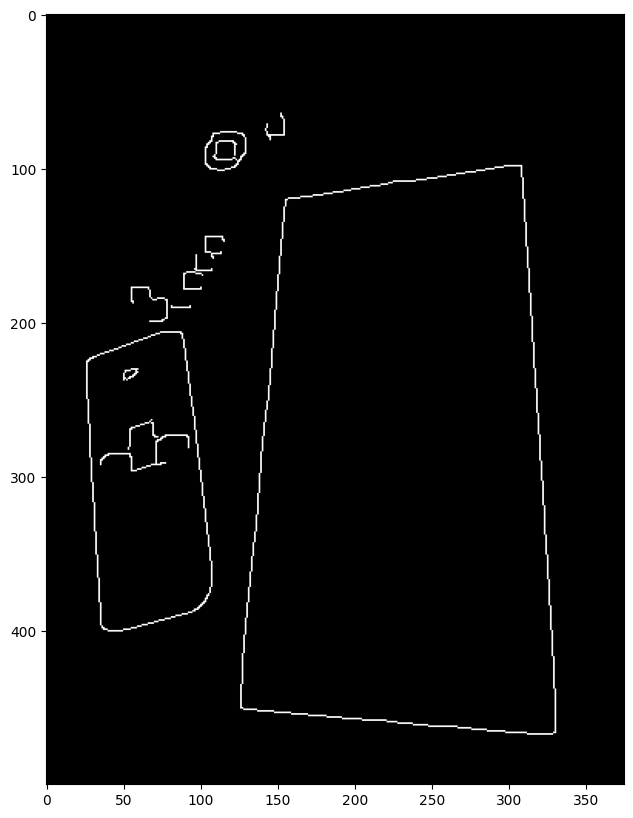

In [67]:

# Deteksi tepi menggunakan operator Canny pada gambar yang telah di-dilate
# Parameter yang diberikan adalah:
# 100: Batas bawah (lower threshold) untuk deteksi tepi.
# 200: Batas atas (upper threshold) untuk deteksi tepi.
# apertureSize=3: Ukuran aperture untuk operator gradien Sobel.
edged = cv2.Canny(dilated, 100, 200, apertureSize=3)
# Tampilkan gambar hasil deteksi tepi
plot_gray(edged)

In [68]:
cv2.__version__

'4.8.0'

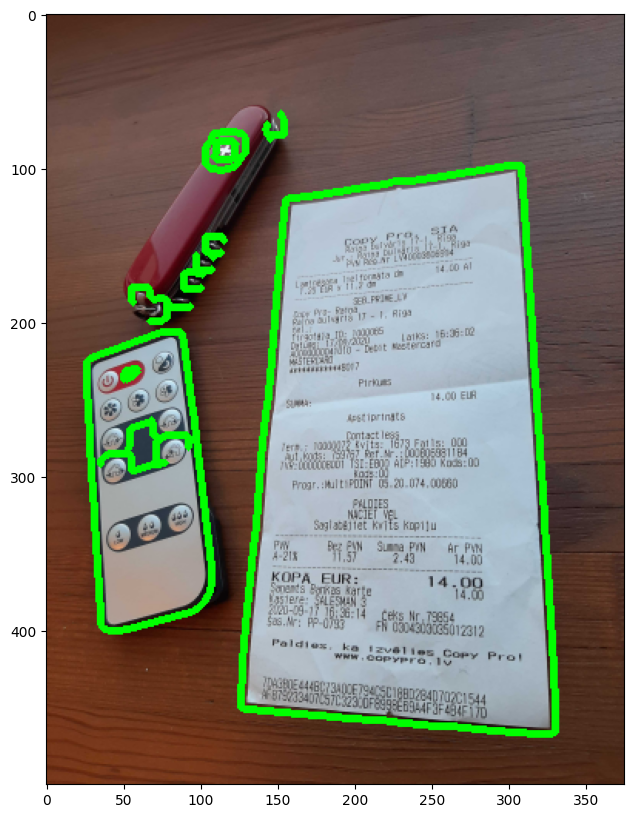

In [69]:
# Detect all contours in Canny-edged image

# Deteksi semua kontur dalam gambar hasil deteksi tepi Canny
contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# Gambar kontur-kontur pada salinan gambar asli
# Parameter yang diberikan adalah:
# contours: Daftar kontur yang akan digambar.
# -1        : Indeks kontur yang akan digambar. Jika nilainya -1, semua kontur akan digambar.
# (0,255,0) : Warna kontur (dalam format BGR), di sini menggunakan warna hijau.
# 3         : Ketebalan garis untuk menggambar kontur.
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
# Tampilkan gambar dengan kontur-kontur yang telah digambar
plot_rgb(image_with_contours)

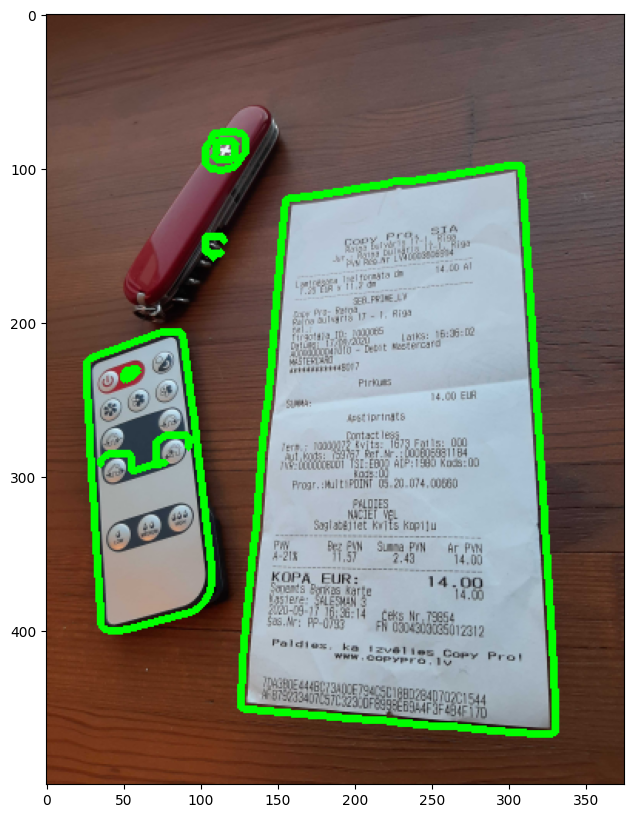

In [70]:
# Get 10 largest contours

# Urutkan kontur berdasarkan luasnya dan ambil 10 kontur terbesar
# Pengurutan daftar kontur secara menurun
largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
# Gambar 10 kontur terbesar pada salinan gambar asli
# Parameter yang diberikan mirip dengan sebelumnya, di mana -1 menandakan bahwa
# semua kontur akan digambar, dan warna garis yang digunakan adalah hijau.
image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
# Tampilkan gambar dengan 10 kontur terbesar yang telah digambar
plot_rgb(image_with_largest_contours)

Dengan menyoroti 10 kontur terbesar, Anda dapat fokus pada area-area tertentu yang memiliki dampak visual yang signifikan dalam gambar.

In [71]:
# Fungsi mengurangi jumlah titik yang merepresentasikan suatu kontur

def approximate_contour(contour):
    # Hitung panjang lengkung (arc length) dari kontur.
    # Parameter True mengindikasikan bahwa kontur adalah tertutup (closed).
    peri = cv2.arcLength(contour, True)
    # Mengaproksimasi kontur dengan poligon.
    # Parameter yang diberikan adalah kontur yang akan diaproksimasi,
    # faktor keakuratan (0.032 kali panjang lengkung), dan indikasi bahwa
    # kontur tersebut tertutup (True).
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

Fungsi ini berguna dalam mengurangi jumlah titik yang digunakan untuk merepresentasikan suatu kontur, sehingga membentuk poligon yang lebih primitif. Penggunaan fungsi ini dapat membantu dalam memahami struktur umum dari suatu objek atau fitur dalam gambar.

In [72]:
def get_receipt_contour(contours):
    # Lakukan iterasi pada daftar kontur yang diberikan
    for c in contours:
        # Mengaproksimasi setiap kontur
        approx = approximate_contour(c)
        # Periksa apakah jumlah titik pada kontur yang diaproksimasi adalah empat.
        # Jika ya, kontur tersebut dapat dianggap sebagai persegi panjang
        if len(approx) == 4:
            # Mengembalikan kontur yang diaproksimasi bila ditemukan kontur yang
            # memiliki empat titik
            return approx

Fungsi ini dapat digunakan untuk mencari kontur yang kemungkinan besar merupakan struk dalam gambar. Jika kontur yang diaproksimasi memiliki empat titik, hal ini menunjukkan kemungkinan besar bahwa kontur tersebut adalah persegi panjang dan dapat dianggap sebagai kontur dari struk.

In [93]:
# Memanggil fungsi untuk mendapatkan kontur struk
receipt_contour = get_receipt_contour(largest_contours)

# Mencetak hasil
print("Receipt Contour Points:\n", receipt_contour)

Receipt Contour Points:
 [[[308  98]]

 [[155 120]]

 [[126 450]]

 [[330 466]]]


Perlu diingat bahwa titik-titik ini mewakili sudut dari persegi panjang yang diaproksimasi dan merupakan hasil dari fungsi get_receipt_contour.

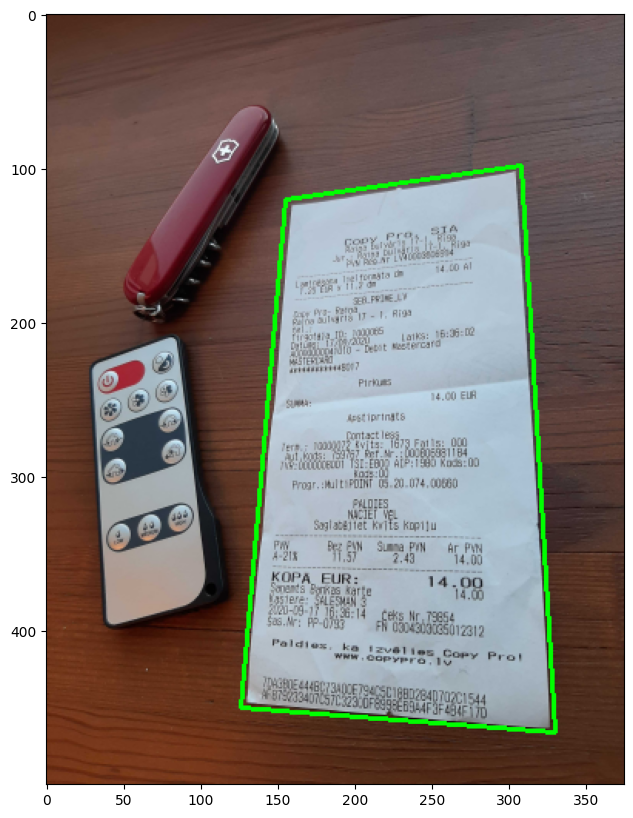

In [74]:
# FYI : Gambar kontur struk pada salinan gambar asli

# Mendapatkan kontur struk
receipt_contour = get_receipt_contour(largest_contours)

# Menggambar kontur struk pada salinan gambar asli
image_with_receipt_contour = cv2.drawContours(image.copy(), [receipt_contour], -1, (0, 255, 0), 2)

# Menampilkan gambar dengan kontur struk yang telah digambar
plot_rgb(image_with_receipt_contour)

Dengan langkah-langkah ini, Anda dapat melihat visualisasi dari kontur yang kemungkinan merupakan struk pada gambar asli.

## **Step 2: Cropping and perspective restoration**
We will make use of cv2.warpPerspective to restore perspective of the receipt. We have to do some preparations though:

1. convert contour into a rectangle-like coordinate array consisting of clockwise ordered points: top-left, top-right, bottom-right, bottom-left
2. use rectangle points to calculate destination points of the "scanned" view
3. feed destination points into cv2.getPerspectiveTransform to calculate transformation matrix
4. and finally use cv2.warpPerspective to restore the perspective!

Following helper methods are inspired by Adrian Rosebrock blog. You can find more details in the resources section.

In [75]:
# Fungsi mengonversi suatu kontur persegi panjang menjadi bentuk array
# yang merepresentasikan sudut-sudut dari persegi panjang.
def contour_to_rect(contour):
    # Ubah array kontur menjadi bentuk array 4x2 dari titik-titik kontur
    pts = contour.reshape(4, 2)

    # Inisialisasi array 4x2 untuk merepresentasikan sudut-sudut dari persegi panjang
    rect = np.zeros((4, 2), dtype="float32")

    # Poin top-left memiliki jumlah paling kecil
    # Poin bottom-right memiliki jumlah paling besar
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # Menghitung perbedaan antara poin-poin:
    # top-right akan memiliki perbedaan minimum
    # bottom-left akan memiliki perbedaan maksimum
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # Membagi hasil dengan faktor perubahan skala
    return rect / resize_ratio

In [76]:
# Fungsi transformasi perspektif pada gambar berdasarkan sudut-sudut
# dari persegi panjang yang mewakili struk
def wrap_perspective(img, rect):
    # Membuka titik sudut persegi panjang: top left, top right, bottom right, bottom left
    (tl, tr, br, bl) = rect

    # Menghitung lebar gambar yang baru
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))

    # Menghitung tinggi gambar yang baru
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))

    # Mengambil nilai maksimum dari lebar dan tinggi untuk mendapatkan dimensi akhir
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))

    # Titik tujuan yang akan digunakan untuk memetakan layar ke tampilan "scan"
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    # Menghitung matriks transformasi perspektif
    M = cv2.getPerspectiveTransform(rect, dst)

    # Melakukan warp perspektif untuk mendapatkan gambar "scan"
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

Now we can make use of helper methods defined to get a perspective version of the receipt:

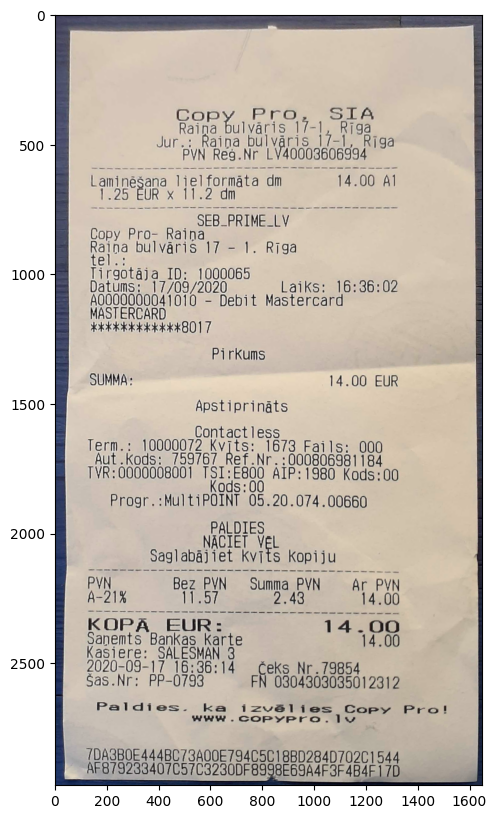

In [77]:
# Melakukan warp perspektif pada gambar asli berdasarkan kontur struk yang diaproksimasi
scanned = wrap_perspective(original.copy(), contour_to_rect(receipt_contour))

# Menampilkan gambar yang telah di-"scan"
plt.figure(figsize=(16,10))
plt.imshow(scanned)

In [78]:
# Fungsi pemindai warna hitam-putih pada suatu gambar
def bw_scanner(image):
    # Mengubah gambar ke skala abu-abu
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Menghitung threshold lokal menggunakan metode Gaussian
    T = threshold_local(gray, 21, offset=5, method="gaussian")

    # Menghasilkan gambar biner (hitam-putih) dengan threshold lokal
    return (gray > T).astype("uint8") * 255

Fungsi ini dapat digunakan untuk mengubah gambar menjadi format hitam-putih dengan kontras yang lebih baik, seringkali berguna dalam pengolahan gambar atau deteksi fitur tertentu.

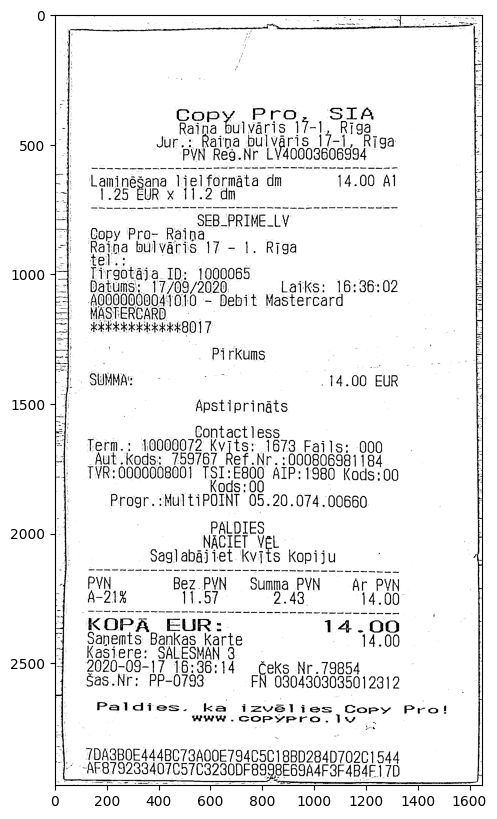

In [79]:
# Menggunakan fungsi bw_scanner untuk mengonversi gambar yang telah di-"scan" menjadi hitam-putih
result = bw_scanner(scanned)

# Menampilkan gambar hitam-putih
plot_gray(result)

Dengan cara ini, Anda dapat melihat hasil gambar yang sudah di-"scan" dan diubah menjadi format hitam-putih, yang mungkin memudahkan dalam proses deteksi dan pengolahan informasi pada gambar tersebut.

Selanjutnya, mengonversi array NumPy (hasil dari pemindaian hitam-putih) menjadi gambar dan menyimpannya dalam format PNG.

In [80]:
# Mengonversi array NumPy menjadi objek gambar menggunakan Image.fromarray
output = Image.fromarray(result)

# Menyimpan gambar ke file PNG dengan nama 'result.png'
output.save('result.png')

We are done with the first part of the Receipt OCR with OpenCV series!

Let's recap:

- At first, we have applied OpenCV preprocessing to get rid of noise and detect contours
- Next, we used heuristics and contour approximation methods to find contour of the receipt
- Finally, we used perspective transformation to obtain top-down view of the receipt

The transformed image is ready for Optical Character Recognition (OCR) which is covered in the next notebook of the series.

# **Receipt OCR Part 2**

The solution is divided into smaller tasks:

1. Get a scanned version of receipt by restoring perspective (done in the previous notebook)
2. **Apply OCR to find all texts within image Find grand total as the largest number among recognized texts**
3. **One should remember that some tasks could be solved with traditional computer vision algorithms**

This work aims to address a common pitfall among machine learning practitioners: trying to solve simple problems with the complex tools.

This is a part two notebook in the Receipt OCR with OpenCV series. Previously we have extracted a scanned version of the receipt out of the image. This notebook deals with the second step of the process: reading text information from it.

1. Locating text boxes on the image
2. Extracting all the texts from the image
3. Obtaining grand total as the largest floating point number among texts

Let's get started!

In [81]:
!apt-get install tesseract-ocr
!apt-get install libtesseract-dev
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 9 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libtesseract-dev is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 9 not upgraded.


Dengan mengimpor modul-modul tersebut, sepertinya Anda bersiap untuk melakukan pengolahan gambar dan ekstraksi teks menggunakan Tesseract OCR.

In [82]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pytesseract
import re

from pytesseract import Output

In [83]:
# Fungsi memvisualisasi gambar dalam skala abu-abu
def plot_gray(image):
    # Membuat figur dengan ukuran 16x10 inci
    plt.figure(figsize=(16,10))

    # Menampilkan gambar dalam skala abu-abu dengan peta warna 'Greys_r'
    return plt.imshow(image, cmap='Greys_r')

In [84]:
# Fungsi memvisualisasi gambar dalam mode warna RGB
def plot_rgb(image):
    # Membuat figur dengan ukuran tertentu
    plt.figure(figsize=(16,10))

    # Mengubah mode warna gambar dari BGR ke RGB dan menampilkannya
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

We will use a scanned version of the receipt, which is the output of the previous notebook in the series:

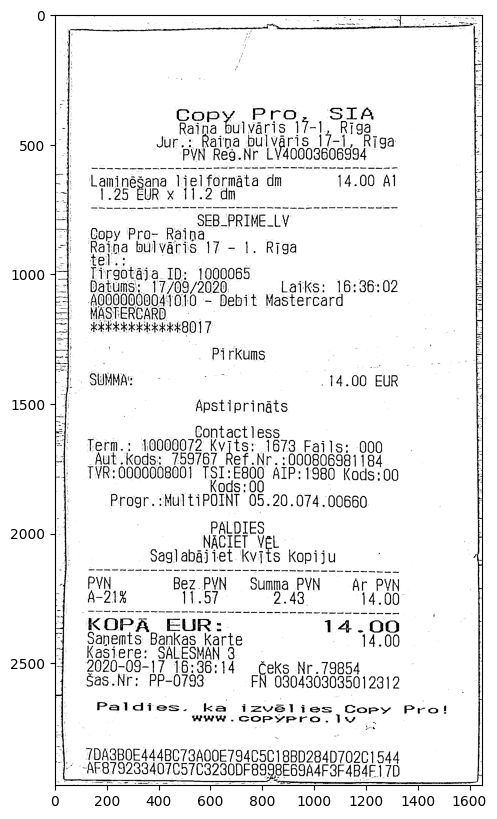

In [85]:
file_name = "result.png"
image = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
plot_gray(image)

## **Step 1: Text box detection**

In [ ]:
!pip install tesseract

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 MB 16.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for tesseract: filename=tesseract-0.1.3-py3-none-any.whl size=45562550 sha256=40bacd76e2402fe9cb8384c0b32a37511dd33e30c4e3220b92b797964fc8528f
  Stored in directory: /root/.cache/pip/wheels/71/c9/aa/698c579693e83fdda9ad6d6f0d8f61ed986e27925ef576f109
Successfully built tesseract


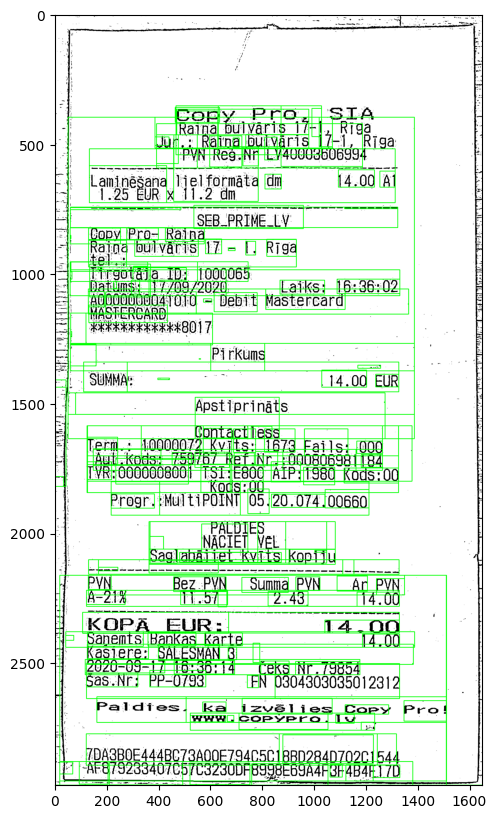

In [86]:
# Deteksi teks dalam gambar dan mengembalikan informasi tentang teks yang terdeteksi
d = pytesseract.image_to_data(image, output_type=Output.DICT)
# Dapatkan jumlah kotak teks yang terdeteksi
n_boxes = len(d['level'])
# Buat salinan gambar skala abu-abu dan konversi dari mode warna BGR ke RGB
boxes = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
# Mengiterasi melalui kotak-kotak yang terdeteksi
for i in range(n_boxes):
    # Gambar kotak di sekitar teks pada gambar RGB.
    # Warna kotak disetel sebagai (0, 255, 0) yang menandakan warna hijau.
    # dan ketebalan garis adalah 2.
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
    boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)
# Tampilkan gambar yang telah diberi kotak di sekitar teks
plot_rgb(boxes)

Dengan ini, Anda dapat melihat kotak di sekitar teks yang terdeteksi oleh Tesseract OCR pada gambar asli.

## **Step 2: Text recognition**

In [87]:
# Ekstrak teks dari gambar dan kembalikan teks yang terdeteksi menggunakan Tesseract OCR
extracted_text = pytesseract.image_to_string(image)
# Cetak teks yang telah diekstrak ke konsol
print(extracted_text)

ao a

Cop
Reis Banari I

 

Si a bulVvaris 1
due pi Res, Nr L\ iBiaddidal
Lannegana iit dm 14.00 Al
oe SEBPRIMELV. SSCS
_ Copy Pro- Raina
Raina bulvaris 17 - 1. Riga
| = mis
: ‘aja_ID: 1000065
: l 5. $7709/2020 Laiks: 16:36:02
AO QO000004T010 = Debit Mastercard .
MASTERCARD.
. POHEREAAKEOIT
— _ Pirkums Je
SUMMA - 1.400 EUR
I mperprimats |

ontact les
Term. 10009072 Oy; ts: 7873 Fails: ‘000
Aut.Kods: 75S 767 Ref .Nr.. ‘000806981 184
TVR: ‘6000008001 Tok: E000 AIP: 1980 Kods:00

Progr. -MuiltiPOINT 05. 20.074 00680

- NAGIET Vet _
Sag] abajiet.'kvits Kopiju

i rt tt

PVN Bez-PVYN Summa PYN Ar PYN.
A-21% 11.57 - 2.43. 14.00
KOPA_EUR: 14.00
-. Sanemts: Bankas Karte 14.00 |
Kasiere: SALESMAN 3 - .
2020-09-17 16:36:14 eks Nr.79854
Sas.Nr: PP-0793 F 0304303036012812
Paldtes. ka izvSlies Copy Pro!
Ww . COPYPro. Iv ye
7BASBOE444BC73A00E794C5C1 8RDZe4D70001 544
[/ 2AF8 7928840705 /C3230DF B99BEBIA4F SF 4B4E 1/0 .



Dengan ini, Anda dapat melihat hasil teks yang berhasil diekstrak dari gambar tersebut

## **Step 3: Extracting grand total**

We will use regular expression to extract all floating point numbers out of the all detected texts.

Fungsi find_amounts yang Anda definisikan di bawah digunakan untuk mencari dan mengembalikan daftar jumlah (angka desimal dengan dua digit di belakang koma) dari teks yang diberikan.

In [94]:
def find_amounts(text):
    # Menggunakan ekspresi reguler untuk menemukan angka desimal
    # dengan dua digit di belakang koma
    amounts = re.findall(r'\d+\.\d{2}\b', text)

    # Mengonversi angka-angka yang ditemukan menjadi float
    floats = [float(amount) for amount in amounts]

    # Menghapus nilai yang duplikat
    unique = list(dict.fromkeys(floats))

    # Mengembalikan daftar nilai unik
    return unique

Dengan begitu dapat menemukan dan mencetak jumlah yang diekstrak dari teks gambar yang telah diberikan sebelumnya

In [89]:
amounts = find_amounts(extracted_text)
amounts

[14.0, 11.57, 2.43]

Output dari kode di atas akan menampilkan daftar nilai unik yang telah ditemukan dalam teks gambar, dengan format angka desimal dua digit di belakang koma.

Grand total is the largest one:

In [90]:
max(amounts)

14.0

Feel free to experiment with other regular expressions to find VAT number, company name, date or even read receipt positions!